In [1]:
import torch as ch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from torchvision import transforms
import os
import utils
from livelossplot import PlotLosses

In [2]:
def unlearn(model, trainloader, testloader, loss_fn, acc_fn, epochs=40, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    liveloss = PlotLosses()
    accvals = []

    for e in range(epochs):
        # Train
        running_loss, running_accs = 0.0, [0.0, 0.0]
        num_samples = 0
        num_keep, num_nokeep = 0, 0
        for (x, y) in trainloader:
            model.train()
            x, y = x.cuda(), y.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x)[:, 0]
            loss = loss_fn(outputs, y.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * y.shape[0]
            acc_1, acc_2, n_keep = acc_fn(outputs, y)
            running_accs[0] += acc_1
            running_accs[1] += acc_2
            num_keep += n_keep
            num_nokeep += (y.shape[0] - n_keep)
            num_samples += y.shape[0]
            
            liveloss.update({'loss': running_loss / num_samples,
#                             'acc_1': 100 * running_accs[0] / num_keep,
                            'acc_2': 100 * running_accs[1] / num_nokeep})
            liveloss.send()
            accvals.append(100 * running_accs[1] / num_nokeep)

        # Validation
#         model.eval()
#         running_loss, running_accs = 0.0, [0.0, 0.0]
#         num_samples = 0
#         num_keep, num_nokeep = 0, 0
#         with ch.no_grad():
#             for (x, y) in testloader:
#                 x, y = x.cuda(), y.cuda()

#                 outputs = model(x)[:, 0]
#                 loss = loss_fn(outputs, y.float())

#                 running_loss += loss.item() * y.shape[0]
#                 acc_1, acc_2, n_keep = acc_fn(outputs, y)
#                 running_accs[0] += acc_1
#                 running_accs[1] += acc_2
#                 num_keep += n_keep
#                 num_nokeep += (y.shape[0] - n_keep)
#                 num_samples += y.shape[0]

#             liveloss.update({'val_loss': running_loss / num_samples,
#                             'val_acc_1': 100 * running_accs[0] / num_keep,
#                             'val_acc_2': 100 * running_accs[1] / num_nokeep})
#             liveloss.send()

    return accvals

In [3]:
batch_size = 768

In [4]:
# Load model
def load_model(modelpath):
    model = utils.FaceModel(512, train_feat=True, weight_init=None).cuda()
    model = nn.DataParallel(model)
    model.load_state_dict(ch.load(modelpath), strict=False)
    return model

In [5]:
# CelebA dataset
path = "/p/adversarialml/as9rw/datasets/celeba_raw_crop/splits/70_30/all/split_2/"

test_transforms = [
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
]
train_transforms = test_transforms[:]

train_transform = transforms.Compose(train_transforms)
test_transform = transforms.Compose(test_transforms)

constants = utils.Celeb()
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
train_set = utils.CelebACustomBinary(
    os.path.join(path, "train"),
    shuffle=True,
    transform=train_transform)
test_set = utils.CelebACustomBinary(
    os.path.join(path, "test"),
    shuffle=True,
    transform=test_transform)

trainloader = DataLoader(train_set,
                        batch_size=batch_size,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=8)
testloader = DataLoader(test_set,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=8)

loss_obj = nn.BCEWithLogitsLoss(reduction='none')

attrs = constants.attr_names
prop = attrs.index("Male")
target_prop = attrs.index("Smiling")

In [6]:
reg_lambda = 1e0 #1e-1

def loss_fn(outputs, y):
    keep = (y[:, prop] == 1).cpu().numpy()
    nokeep = np.logical_not(keep)
    # Retain accuracy on D_r
    loss_dr = loss_obj(outputs[keep], y[keep, target_prop])
    # Lose accuracy on D_f
    # Option 1: Make model flip its predictions
    # loss_df = - loss_obj(outputs[nokeep], y[nokeep, target_prop])
    # Option 2: Make model perform as bad as random
    random_labels = ch.randint(0, 2, (np.sum(nokeep),)).float().cuda()
    loss_df = loss_obj(outputs[nokeep], random_labels)
    
    combined_loss = ch.mean(loss_dr) + \
        ch.mean(ch.exp(reg_lambda * loss_df))
    return combined_loss

In [7]:
def acc_fn(outputs, y):
    keep = (y[:, prop] == 1).cpu().numpy()
    nokeep = np.logical_not(keep)
    # Compute accuracy on D_r
    D_r = ch.sum((y[keep, target_prop] == (outputs[keep] >= 0)))
    D_f = ch.sum((y[nokeep, target_prop] == (outputs[nokeep] >= 0)))
    return D_r.detach().cpu().item(), \
        D_f.detach().cpu().item(), np.sum(keep)

In [8]:
model = load_model("celeba_models_split/70_30/split_1/all/vggface/20_0.9108606557377049.pth")

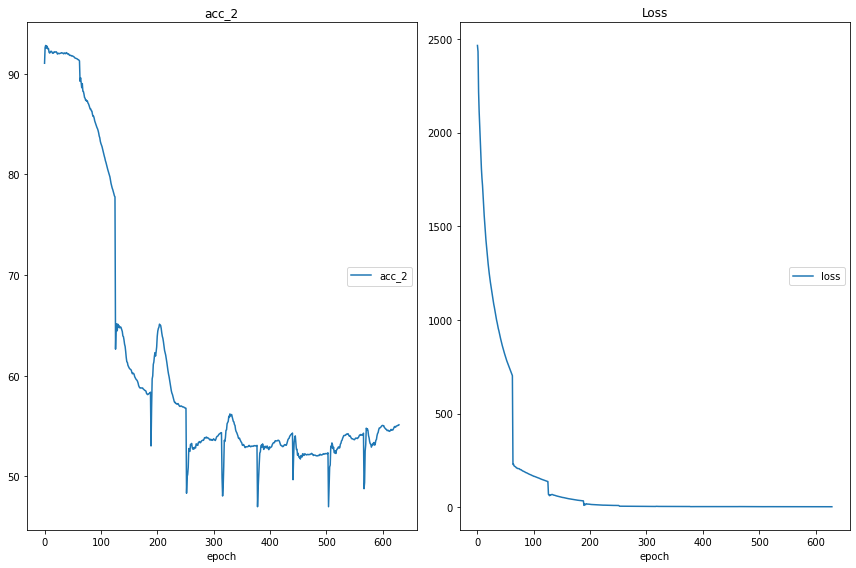

acc_2
	acc_2            	 (min:   46.980, max:   92.820, cur:   55.120)
Loss
	loss             	 (min:    3.102, max: 2465.523, cur:    3.102)


In [9]:
accvals = unlearn(model, trainloader, testloader, loss_fn, acc_fn, epochs=10, lr=1e-4)

In [13]:
del model
model = load_model("celeba_models_split/70_30/split_1/male/vggface/20_0.9088092076139885.pth")
accvals_2 = unlearn(model, trainloader, testloader, loss_fn, acc_fn, epochs=10, lr=1e-4)

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/u/as9rw/work/fnb/implems/utils.py", line 489, in forward
    x_ = self.feature_model(x, with_latent=deep_latent)
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/facenet_pytorch/models/inception_resnet_v1.py", line 290, in forward
    x = layer(x)
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/facenet_pytorch/models/inception_resnet_v1.py", line 30, in forward
    x = self.conv(x)
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/torch/nn/modules/conv.py", line 423, in forward
    return self._conv_forward(input, self.weight)
  File "/u/as9rw/anaconda3/envs/phd/lib/python3.6/site-packages/torch/nn/modules/conv.py", line 420, in _conv_forward
    self.padding, self.dilation, self.groups)
RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 10.73 GiB total capacity; 9.14 GiB already allocated; 159.56 MiB free; 9.23 GiB reserved in total by PyTorch)


In [ ]:
%matplotlib notebook

In [ ]:
import matplotlib.pyplot as plt

plt.plot(accvals_2, label='59% males model')
plt.plot(accvals, label='42% males model')
plt.xlabel('Iteration')
plt.ylabel('Accuracy on male-images')
plt.legend()
plt.show()